# **LeNet FashionMNIST**
Objective
- Intro coding for CNN





## **LeNet Network**

The LeNet network has 5 layers with learnable parameters. It has three sets of convolution layers with a combination of average pooling. After the convolution and average pooling layers, it has two fully connected layers. At last, a Softmax classifier which classifies the images into respective class.

This network accepts an input of 32 x 32 and then passes through the following layers:

#### **First Layer**

This layer is a 5 x 5 Conv2d layer with a stride of 1 and 6 filters, followed by a 2 x 2 pooling layer with stride 2.

- input: 32 x 32 x 1
- after convolution: 28 x 28 x 6
- after pooling: 14 x 14 x 6

#### **Second Layer**

This layer is a 5 x 5 Conv2d layer with a stride of 1 and 16 filters, followed by a 2 x 2 pooling layer with stride 2.

- input: 14 x 14 x 6
- after convolution: 10 x 10 x 16
- after pooling: 5 x 5 x 16

#### **Third Layer**

This layer is a 5 x 5 Conv2d layer with a stride of 1 and 120 filters.

- input: 5 x 5 x 16
- after convolution: 1 x 1 x 120 (120)

#### **Fourth Layer**

The next is a fully connected layer with 84 neurons that result in the output to 84 values.

- input: 120
- output: 84

#### **Fifth Layer**

The last layer is a fully connected layer with 10 neurons and a softmax function. The Softmax gives the probability that a data point belongs to a particular class. The highest value is then predicted.

- input: 84
- after fully connected layer: 10
- after softmax function: 1


This is the entire architecture of the Lenet model. The number of trainable parameters of this architecture is around sixty thousand.

- Use Tanh as non-linearity
- No use of Dropout or BatchNorm

# Import libraries

In [ ]:
# Importing the necessary libraries
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchsummary import summary

from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR, CyclicLR, OneCycleLR, StepLR

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import random

from datetime import datetime
from pathlib import Path
import plotly.io as pio
pio.renderers.default = 'colab'

In [ ]:
# Import random function
import random

# Fix seed value
SEED = 2345
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_folder = Path('/content/drive/MyDrive/Data/DL')

In [ ]:
lecture_folder = Path('/content/drive/MyDrive/teaching_fall_2021/dl_fall_2021/Lecture_9_CNN_part_2')

We will be using W&B for visualization.

In [ ]:
# Install wandb and update it to the latest version
%%capture
!pip install wandb --upgrade

In [ ]:
# Import wandb
import wandb

# Login to W&B
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# **Fashion-MNIST Dataset**

Fashion-MNIST dataset consists of images from 10 categories, each represented by 6000 images in the training dataset and by 1000 in the test dataset. Thus, train set contains 60000 images and test set 10000 images.

All the images are grayscale with dimensions 28 x 28.

Categories present in the dataset: t-shirt, trousers, pullover, dress, coat, sandal, shirt, sneaker, bag, and ankle boot.

Let us download the dataset using some built-in functions.

We will first convert the images in the dataset to pytorch tensors using torchvision.transforms and then normalize them.

Next, we will use torchvision.datasets for downloading the fashion MNIST  datasets and apply transform that we defines earlier. 

- `trainset` conains the training data
- `testset` contains the testing data

## Train and Test Dataset

In [ ]:
# Transform to convert images to pytorch tensors and normalize the data
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.2860,), (0.3530,))])
train_full = torchvision.datasets.FashionMNIST(root=data_folder,
                                              train=True, 
                                              transform=trans,
                                              download=True)
trainset, validset = torch.utils.data.random_split(train_full, [50000, 10000], generator=torch.Generator().manual_seed(42) )
testset  = torchvision.datasets.FashionMNIST(root=data_folder,
                                              train=False, 
                                              transform=trans,
                                              download=True)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning:

The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)



### Check inputs

In [ ]:
# Shape of training data
train_full.data.shape

torch.Size([60000, 28, 28])

In [ ]:
trainset.dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: /content/drive/MyDrive/Data/DL
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.286,), std=(0.353,))
           )

In [ ]:
len(trainset.dataset)

60000

In [ ]:
len(trainset.indices)

50000

In [ ]:
# Shape of testing data
testset.data.shape

torch.Size([10000, 28, 28])

In [ ]:
# check the max value of inputs
train_full.data.max()

tensor(255, dtype=torch.uint8)

In [ ]:
# check the min value of inputs
train_full.data.min()

tensor(0, dtype=torch.uint8)

In [ ]:
# check the min value of inputs
train_full.data.float().mean()/255

tensor(0.2860)

In [ ]:
# check the min value of inputs
train_full.data.float().std()/255

tensor(0.3530)

### Check Labels

In [ ]:
# check target values for train set
train_full.targets.shape

torch.Size([60000])

In [ ]:
# Unique Target values
train_full.targets.unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

There are 10 different target values or the features present in our dataset.

### Check Transformation

- Check if transformation are working correctly.
- The transformations are applied at the time of calling dataloader

In [ ]:
check_loader = torch.utils.data.DataLoader(trainset, batch_size = 32, shuffle = True)

In [ ]:
# check number of batches
len(check_loader)

1563

In [ ]:
1563*32

50016

In [ ]:
# check total training examples
len(check_loader.dataset)

50000

In [ ]:
# check imputs and outputs 
for input, target in check_loader:
  print(f'shape of inputs is :{input.shape}')
  print(f'\nmax input value  :{input.max()}')
  print(f'\nmin input value  :{input.min()}')
  print(f'\nmean input value  :{input.mean()}')
  print(f'\nstd input value  :{input.std()}')
  print(f'\nshape of targets is :{target.shape}')
   
  break

shape of inputs is :torch.Size([32, 1, 28, 28])

max input value  :2.022662878036499

min input value  :-0.8101983666419983

mean input value  :-0.008474037051200867

std input value  :0.9932664632797241

shape of targets is :torch.Size([32])


First let's define labels for our dataset as dataset contains numerical values for now.

## Get Labels

In [ ]:
def get_fashion_mnist_labels(labels):  
    """ 
    Function to generate labels.
    Input: numerical labels
    Output: actual string labels
    """

    # Create a list of labels
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

    # Return text_labels according to numerical values
    return [text_labels[int(i)] for i in labels]

# Model LeNet

# code here - Use sigmoid as non -linearity.

In [ ]:
16 * 25 + 16

416

In [ ]:
class LeNet(nn.Module):

    def __init__(self):
      super().__init__()

      # 32 - 5 + 1 = 28
      # 14 - 5 + 1 = 10

      self.feature_extractor = nn.Sequential(
          nn.Conv2d(in_channels=1, out_channels=6,kernel_size=(5,5), stride=1, padding=2), # 28 x 28; 6 bias, 6 kernels, 6*25 +6
          nn.Sigmoid(),
          nn.AvgPool2d(kernel_size = (2, 2), stride = 2), # 28-2 = 26/2 = 13 + 1 = 14; 14 x 14; 0 parameters no weights
          
          nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5,5), stride=1, padding=0), # 10 x 10; est. param = 6 * 16 * 25 + 16
          nn.Sigmoid(),
          nn.AvgPool2d(kernel_size = (2, 2), stride = 2), # 5 x 5

          nn.Conv2d(in_channels=16, out_channels=120, kernel_size=(5,5), stride=1, padding=0), # extract 120 features; 1 x 1
          nn.Sigmoid()
      )

      self.classifier = nn.Sequential(
          nn.Linear(in_features=120, out_features=84), #*** Need to understand; 84
          nn.Sigmoid(),
          
          nn.Linear(in_features=84, out_features=10), # 10
      )


    def forward (self, x):
        x = self.feature_extractor(x)
        x = torch.nn.Flatten(x)
        output = self.classifier(x)

        return output 

      # # layer1
      # conv1 = torch.nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = (5,5), stride= 1)
      # output1_1 = conv1(input)

      # # pool1
      # pool1 = torch.nn.AvgPool2d(kernel_size = (2, 2), stride = 2)
      # output1 = pool1(output1_1)

## want initial loss in epic to be 0.6, 0.7 else need to change lr 



In [ ]:
28 * 28 * 6

4704

In [ ]:
32*32

1024

In [ ]:
summary(LeNet().cuda(), (1, 28, 28))

TypeError: ignored

# Training Functions

## Training Epoch 

In [ ]:
def train(train_loader, model, optimizer, loss_function, log_batch, log_interval, grad_clipping, max_norm):

  """ 
  Function for training the model in each epoch
  Input: iterator for train dataset, initial weights and bias, epochs, learning rate.
  Output: final weights, bias, train loss, train accuracy
  """
  # initilalize variables as global
  # these counts will be updated every epoch
  global example_ct_train
  global batch_ct_train

  # Training Loop loop
  # Initialize train_loss at the he start of the epoch
  running_train_loss = 0
  running_train_correct = 0
  
  # put the model in training mode
  model.train()

  # Iterate on batches from the dataset using train_loader
  for input, targets in train_loader:
    
    # move inputs and outputs to GPUs
    input = input.to(device)
    targets = targets.to(device)

    # Forward pass
    output = model(input)
    loss = loss_function(output, targets)

    # Correct prediction
    y_pred = torch.argmax(output, dim = 1)
    correct = torch.sum(y_pred == targets)

    example_ct_train +=  len(targets)
    batch_ct_train += 1

    # set gradients to zero 
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Gradient Clipping
    if grad_clipping:
      nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_norm, norm_type=2)

    # Update parameters using their gradient
    optimizer.step()
          
    # Add train loss of a batch 
    running_train_loss += loss.item()

    # Add Corect counts of a batch
    running_train_correct += correct

    # log batch loss and accuracy
    if log_batch:
      if ((batch_ct_train + 1) % log_interval) == 0:
        wandb.log({f"Train Batch Loss  :": loss})
        wandb.log({f"Train Batch Acc :": correct/len(targets)})

  
  # Calculate mean train loss for the whole dataset for a particular epoch
  train_loss = running_train_loss/len(train_loader)



  # Calculate accuracy for the whole dataset for a particular epoch
  train_acc = running_train_correct/len(train_loader.dataset)

  return train_loss, train_acc

## Validation/Test Epoch

In [ ]:
def valid(loader, model, optimizer, loss_function, log_batch, log_interval):

  """ 
  Function for training the model and plotting the graph for train & valid loss vs epoch.
  Input: iterator for train dataset, initial weights and bias, epochs, learning rate, batch size.
  Output: final weights, bias and train loss and valid loss for each epoch.
  """

  # initilalize variables as global
  # these counts will be updated every epoch
  global example_ct_valid
  global batch_ct_valid

  # Validation loop
  # Initialize train_loss at the he strat of the epoch
  running_valid_loss = 0
  running_valid_correct = 0
  
  # put the model in evaluation mode
  model.eval()

  with torch.no_grad():
    for input,targets in loader:

      # move inputs and outputs to GPUs
      input = input.to(device)
      targets = targets.to(device)

      # Forward pass
      output = model(input)
      loss = loss_function(output,targets)

      # Correct Predictions
      y_pred = torch.argmax(output, dim = 1)
      correct = torch.sum(y_pred == targets)

      # count of images and batches
      example_ct_valid +=  len(targets)
      batch_ct_valid += 1

      # Add valid loss of a batch 
      running_valid_loss += loss.item()

      # Add correct count for each batch
      running_valid_correct += correct

      # log batch loss and accuracy
      if log_batch:
        if ((batch_ct_valid + 1) % log_interval) == 0:
          wandb.log({f"Valid Batch Loss  :": loss})
          wandb.log({f"Valid Batch Accuracy :": correct/len(targets)})


    # Calculate mean valid loss for the whole dataset for a particular epoch
    valid_loss = running_valid_loss/len(valid_loader)

    # scheduler step
    # scheduler.step(valid_loss)
    # scheduler.step()

    # Calculate accuracy for the whole dataset for a particular epoch
    valid_acc = running_valid_correct/len(valid_loader.dataset)
    
  return valid_loss, valid_acc

##  Model Training Loop


In [ ]:
def train_loop(train_loader, valid_loader, model, loss_function, optimizer, epochs, device, patience, early_stopping,
               file_model):

  '''
  model: specify your model for training
  criterion: loss function 
  optimizer: optimizer like SGD , ADAM etc.
  train loader: function to carete batches for training data
  loader : function to create batches for valid data set
  file_model : specify file name for saving your model. This way we can upload the model weights from file. We will not to run model again.
  

  '''
  # Create lists to store train and valid loss at each epoch

  train_loss_history = []
  valid_loss_history = []
  train_acc_history = []
  valid_acc_history = []
  delta = 0
  best_score = None
  valid_loss_min = np.Inf
  counter_early_stop=0
  early_stop=False


  # Iterate for the given number of epochs
  for epoch in range(epochs):
    t0 = datetime.now()
    # Get train loss and accuracy for one epoch

    train_loss, train_acc = train(train_loader, model, optimizer, loss_function, 
                                  wandb.config.log_batch, wandb.config.log_interval,
                                  wandb.config.grad_clipping, wandb.config.max_norm)
    valid_loss, valid_acc = valid(valid_loader, model, optimizer, loss_function,
                                    wandb.config.log_batch, wandb.config.log_interval)

    dt = datetime.now() - t0

    # Save history of the Losses and accuracy
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    valid_loss_history.append(valid_loss)
    valid_acc_history.append(valid_acc)

    if early_stopping:
      score = -valid_loss
      if best_score is None:
        best_score=score
        print(f'Validation loss has decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving Model...')
        torch.save(model.state_dict(), file_model)
        valid_loss_min = valid_loss

      elif score < best_score + delta:
        counter_early_stop += 1
        print(f'Early stoping counter: {counter_early_stop} out of {patience}')
        if counter_early_stop > patience:
          early_stop = True

      
      else:
        best_score = score
        print(f'Validation loss has decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), file_model)
        counter_early_stop=0
        valid_loss_min = valid_loss

      if early_stop:
        print('Early Stopping')
        break

    else:

      score = -valid_loss
      if best_score is None:
        best_score=score
        print(f'Validation loss has decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving Model...')
        torch.save(model.state_dict(), file_model)
        valid_loss_min = valid_loss

      elif score < best_score + delta:
        print(f'Validation loss has not decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Not Saving Model...')
      
      else:
        best_score = score
        print(f'Validation loss has decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), file_model)
        valid_loss_min = valid_loss



    # Log the train and valid loss to W&B
    wandb.log({f"Train epoch Loss :": train_loss, f"Valid epoch Loss :": valid_loss })
    wandb.log({f"Train epoch Acc :": train_acc, f"Valid epoch Acc :": valid_acc})



    # Print the train loss and accuracy for given number of epochs, batch size and number of samples
    print(f'Epoch : {epoch+1} / {epochs}')
    print(f'Time to complete {epoch+1} is {dt}')
    #print(f'Learning rate: {scheduler._last_lr[0]}')
    print(f'Train Loss: {train_loss : .4f} | Train Accuracy: {train_acc * 100 : .4f}%')
    print(f'Valid Loss: {valid_loss : .4f} | Valid Accuracy: {valid_acc * 100 : .4f}%')
    print()
    torch.cuda.empty_cache()

  return train_loss_history, train_acc_history, valid_loss_history, valid_acc_history


#Model Training

## **Meta data**



In [ ]:
hyperparameters = dict(
    epochs = 25,
    output_dim = 10, 
    
    batch_size = 256,
    learning_rate = 0.9,
    dataset="FashionMNIST",
    architecture="LeNet",
    log_interval = 25,
    log_batch = True,
    file_model = lecture_folder/'lenet_fmnist.pt',
    grad_clipping = False,
    max_norm = 1,
    patience = 5,
    early_stopping = True,
    weight_decay = 0,
    scheduler_factor = 0.5,
    scheduler_patience = 0,
   )

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Initialize wandb

In [ ]:
wandb.init(name = 'L_9_lenet_fmnist', project = 'CNN_Intro', config = hyperparameters)

wandb: Currently logged in as: hsingh-utd (use `wandb login --relogin` to force relogin)


In [ ]:
wandb.config.device = device
print(wandb.config.device )

cuda:0


## Specify Dataloader, Loss_function, Model, Optimizer, Weight Initialization

In [ ]:
# Fix seed value
SEED = 2345
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Data Loader
train_loader = torch.utils.data.DataLoader(trainset, batch_size=wandb.config.batch_size, shuffle = True)
valid_loader = torch.utils.data.DataLoader(validset, batch_size=wandb.config.batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(testset, batch_size=wandb.config.batch_size,   shuffle = False)

# cross entropy loss function
loss_function = nn.CrossEntropyLoss()

# device 
model = LeNet()

def init_weights(m):
  if type(m) == nn.Conv2d:
        torch.nn.init.kaiming_normal_(m.weight)
        torch.nn.init.zeros_(m.bias)

  if type(m) == nn.Conv2d:
        torch.nn.init.kaiming_normal_(m.weight)
        torch.nn.init.zeros_(m.bias)

# Use Default Init        
# apply initialization recursively  to all modules
#model.apply(init_weights)

wandb.config.init_weights = init_weights

# put model to GPUs
model.to(wandb.config.device)

# Intialize stochiastic gradient descent optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

wandb.config.optimizer = optimizer

'''
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor= wandb.config.scheduler_factor, 
                              patience=wandb.config.scheduler_patience, verbose=True)
'''

#scheduler = StepLR(optimizer, gamma=0.4,step_size=1, verbose=True)

"\nscheduler = ReduceLROnPlateau(optimizer, mode='min', factor= wandb.config.scheduler_factor, \n                              patience=wandb.config.scheduler_patience, verbose=True)\n"

## Sanity Check
- Check the loss without any training. For Cross entropy the expected value will be log(number of classes)

In [ ]:
# Fix seed value

SEED = 2345
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

for input, targets in train_loader:
  
  # move inputs and outputs to GPUs
  input = input.to(device)
  targets = targets.to(device)
  model.eval()
  # Forward pass
  output = model(input)
  loss = loss_function(output, targets)
  print(f'Actual loss: {loss}')
  break

print(f'Expected Theoretical loss: {np.log(10)}')



Actual loss: 2.349172592163086
Expected Theoretical loss: 2.302585092994046


## Train Model and Save best model

In [ ]:
wandb.watch(model, log = 'all', log_freq=25, log_graph=True)

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [ ]:
example_ct_train, batch_ct_train, example_ct_valid, batch_ct_valid = 0, 0, 0, 0
train_loss_history, train_acc_history, valid_loss_history, valid_acc_history = train_loop(train_loader, valid_loader, model, loss_function, optimizer, 
                                                                                          wandb.config.epochs, wandb.config.device,
                                                                                          wandb.config.patience, wandb.config.early_stopping,
                                                                                          wandb.config.file_model)

Validation loss has decreased (inf --> 2.312278). Saving Model...
Epoch : 1 / 25
Time to complete 1 is 0:00:13.932855
Train Loss:  2.3172 | Train Accuracy:  9.9820%
Valid Loss:  2.3123 | Valid Accuracy:  9.8500%

Validation loss has decreased (2.312278 --> 2.299034). Saving model...
Epoch : 2 / 25
Time to complete 2 is 0:00:13.892695
Train Loss:  2.3032 | Train Accuracy:  10.3500%
Valid Loss:  2.2990 | Valid Accuracy:  9.4500%

Validation loss has decreased (2.299034 --> 1.264279). Saving model...
Epoch : 3 / 25
Time to complete 3 is 0:00:13.643708
Train Loss:  1.6609 | Train Accuracy:  34.8000%
Valid Loss:  1.2643 | Valid Accuracy:  49.4500%

Validation loss has decreased (1.264279 --> 0.937938). Saving model...
Epoch : 4 / 25
Time to complete 4 is 0:00:13.208131
Train Loss:  1.0057 | Train Accuracy:  59.2980%
Valid Loss:  0.9379 | Valid Accuracy:  62.1100%

Validation loss has decreased (0.937938 --> 0.755497). Saving model...
Epoch : 5 / 25
Time to complete 5 is 0:00:13.715378
Train

## Add Visulaization

### Add training images

In [ ]:
# Get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# Create grid of images
img_grid = torchvision.utils.make_grid(images[0:50], nrow = 5)

# Logging to W&B
images = wandb.Image(img_grid, caption = "Sample images")
wandb.log({"examples": images})

### Add Loss plot

In [ ]:
# Plot the train loss and test loss per iteration
fig = plt.figure(0)
plt.plot(train_loss_history, label = 'train loss')
plt.plot(valid_loss_history, label = 'valid loss')
plt.legend()

# Log the plot to W&B
wandb.log({"train-test loss per epoch": fig})

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



# **Accuracy and Predictions**

Now we have final values for weights and bias after training the model. We will use these values to make predictions on the test dataset.

## Function to get predictions

In [ ]:
def get_acc_pred(data_loader, model):
  """ 
  Function to get predictions for a given test set and calculate accuracy.
  Input: Iterator to the test set.
  Output: Prections and Accuracy for test set.
  """
  with torch.no_grad():
    # Array to store predicted labels
    predictions = torch.Tensor()
    predictions = predictions.to(device)

    # Array to store actual labels
    y = torch.Tensor()
    y = y.to(device)
    # Iterate over batches from test set
    for input, targets in data_loader:
      
      # move inputs and outputs to GPUs
      input = input.to(device)
      targets = targets.to(device)

      # Calculated the predicted labels
      output = model(input)

      # Choose the label with maximum probability
      indices = torch.argmax(output, dim = 1)

      # Add the predicted labels to the array
      predictions = torch.cat((predictions, indices)) 

      # Add the actual labels to the array
      y = torch.cat((y, targets)) 

    # Check for complete dataset if actual and predicted labels are same or not
    # Calculate accuracy
    acc = (predictions == y).float().mean()

  # Return array containing predictions and accuracy
  return predictions, acc
  

## Load saved model from file 

In [ ]:
model_nn =  LeNet()
model_nn.to(device)
model_nn.load_state_dict(torch.load(wandb.config.file_model))

<All keys matched successfully>

In [ ]:
print(wandb.config.file_model)

/content/drive/MyDrive/teaching_fall_2021/dl_fall_2021/Lecture_9_CNN_part_2/lenet_fmnist.pt


In [ ]:
# Get the prediction and accuracy for the test dataset
predictions, acc_test = get_acc_pred(test_loader, model_nn)

In [ ]:
# Print Accuracy for test dataset
print(acc_test * 100)
wandb.config.test_accuracy = acc_test

tensor(85.0400, device='cuda:0')


**We have obtained 85 % accuracy on test dataset.**


## **Visualizations on Predictions**

Now, we will make some visualizations for the predictions that we obtained.

We will construct a `confusion matrix` which will help us to visualize the performance of our classification model on the test dataset as we know the true values for the test data.

In [ ]:
# Get an array containing actual labels
testing_labels = testset.targets.numpy()

In [ ]:
# Import libraries for building the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

# Define the values for classes
classes = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
           'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']


In [ ]:
# Log a confusion matrix to W&B
wandb.log({"conf_mat" : wandb.plot.confusion_matrix(
                        probs = None,
                        y_true = testing_labels,
                        preds = predictions.to('cpu').numpy(),
                        class_names = classes)})


Let us look at some of the images from test class and see the actual and predicted labels.

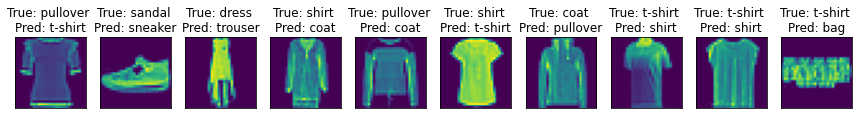

In [ ]:
# Initialize number of images to be displayed
n = 10

# Convert predictions to integer numpy array
predictions = predictions.to('cpu').numpy()
predictions = predictions.astype(np.int)

# Get some random misclassified images
misclassified_idx = np.argwhere(predictions != testing_labels).flatten()

# Select indexed for 10 random misclassified images
i = np.random.choice(misclassified_idx, n)

# Get the actual and predicted labels for the 10 misclassified images
trues = get_fashion_mnist_labels(testing_labels[i])
preds = get_fashion_mnist_labels(predictions[i])

# Zip the actual and predicted labels to be used further
titles = [true +'\n' + pred for true, pred in zip(trues, preds)]

# Store the 10 images to be displayed in the format of 28 x 28
images = testset.data[i].view(n, 28, 28)

# Plot the images
fig = plt.figure(figsize = (15, 65))
for idx in np.arange(n):
    ax = fig.add_subplot(1, 10, idx+1, xticks = [], yticks = [])
    plt.imshow(images[idx])
    ax.set_title("True: {0} \nPred: {1}".format(trues[idx], preds[idx]))

# Log the plot to W&B
wandb.log({"Misclassifications": fig})


In [ ]:
wandb.finish()

Train Batch Acc :,▁▁▁▁▄▅▆▆▆▇▇▇▇█▇▇▇▇█▇██▇▇▇█████▇██▇██████
Train Batch Loss :,████▅▄▃▃▃▂▂▂▂▁▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
Train epoch Acc :,▁▁▃▅▆▇▇▇▇▇████████████
Train epoch Loss :,██▆▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Valid Batch Accuracy :,▁▁▁▅▆▅▆▇▇▇▇▇▇▇▆▆█▇▇██▇██████████▇███
Valid Batch Loss :,███▄▃▃▃▂▂▂▂▂▂▂▃▃▁▂▂▁▁▂▁▁▁▁▁▂▁▁▁▁▂▂▂▁
Valid epoch Acc :,▁▁▅▆▇▇▇▇▇▆█▇████████▇█
Valid epoch Loss :,██▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▁
Train Batch Acc :,0.86328
Train Batch Loss :,0.34989
Train epoch Acc :,0.86896


Here, we can observe that most of the items were misclassified because of the similarities in their features.